In [ ]:
from google.colab import files
files.upload()

In [80]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [81]:
! cp kaggle.json ~/.kaggle

In [82]:
! chmod 600 ~/.kaggle/kaggle.json

In [83]:
!kaggle datasets download -d gpiosenka/100-bird-species 

100-bird-species.zip: Skipping, found more recently modified local copy (use --force to force download)


In [84]:
import zipfile

unzip = zipfile.ZipFile("100-bird-species.zip","r")
unzip.extractall()
unzip.close()

##**Data Visualization**

In [85]:
import cv2
img = cv2.imread("/content/one image to test/1.jpg")
img.shape

(224, 224, 3)

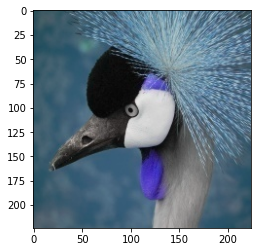

In [86]:
import matplotlib.pyplot as plt

plt.imshow(img)
plt.show()

##**Data processing**

In [87]:
train_dir = "/content/train"
test_dir = "/content/test"
val_dir = "/content/valid"

##**Processing data for Efficientnet**

In [88]:
import tensorflow as tf

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                     label_mode = "categorical",
                                                                     image_size = (224,224),
                                                                     batch_size = 32
                                                                     )
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                    label_mode = "categorical",
                                                                    image_size = (224,224),
                                                                    batch_size = 32
                                                                    )
val_data = tf.keras.preprocessing.image_dataset_from_directory(val_dir,
                                                                   label_mode= "categorical",
                                                                   image_size = (224,224),
                                                                   batch_size = 32
                                                                   )

Found 45980 files belonging to 315 classes.
Found 1575 files belonging to 315 classes.
Found 1575 files belonging to 315 classes.


In [89]:
len(train_data.class_names)

315

In [90]:
labels_names = train_data.class_names


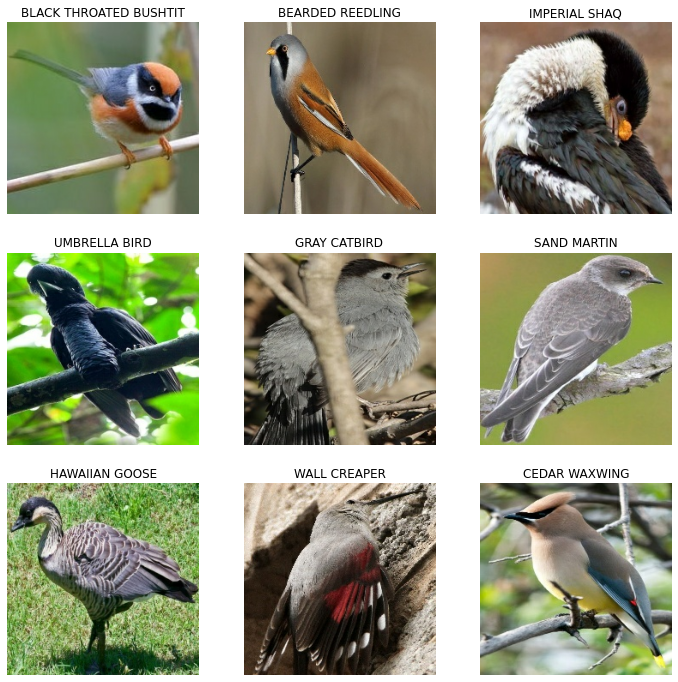

In [91]:
# visualizing the images
import matplotlib.pyplot as plt
import tensorflow as tf

plt.figure(figsize=(12,12))
for image, label in train_data.take(1):
  
  for i in range(9):
    
    plt.subplot(3,3, i+1)  
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.title(labels_names[tf.argmax(label[i])])
    plt.axis("off")


In [92]:
# building a efficientnet model
import tensorflow as tf

base_model = tf.keras.applications.EfficientNetB5(include_top= False, weights = "imagenet")


In [93]:
import tensorflow as tf
from tensorflow.keras import layers

for layer in base_model.layers[:-5]:
  base_model.trainable = False


inputs = tf.keras.Input(shape=(224,224,3))

x = base_model(inputs)
x = layers.GlobalAveragePooling2D()(x)


outputs = layers.Dense(315, activation="softmax")(x)

eff_model = tf.keras.Model(inputs,outputs)


In [94]:
eff_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb5 (Functional)  (None, None, None, 2048)  28513527 
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 315)               645435    
                                                                 
Total params: 29,158,962
Trainable params: 645,435
Non-trainable params: 28,513,527
_________________________________________________________________


In [95]:
# compiling the model

eff_model.compile(
    loss = tf.keras.losses.categorical_crossentropy,
    optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001),
    metrics = ["accuracy"]
)

In [96]:
# fitting data to the model

eff_model.fit(train_data,
              epochs = 2,
              steps_per_epoch = len(train_data),
              validation_data = val_data,
              validation_steps = len(val_data)
              )

Epoch 1/2
1437/1437 [==============================] - 705s 479ms/step - loss: 1.0304 - accuracy: 0.8100 - val_loss: 0.1985 - val_accuracy: 0.9619
Epoch 2/2
1437/1437 [==============================] - 685s 476ms/step - loss: 0.2781 - accuracy: 0.9373 - val_loss: 0.1312 - val_accuracy: 0.9683


In [97]:
eff_model_evaluation = eff_model.evaluate(test_data)

50/50 [==============================] - 23s 447ms/step - loss: 0.1057 - accuracy: 0.9797


In [98]:
print(f"Effcient Model Accuracy: {eff_model_evaluation[1]*100 : 0.2f}%")

Effcient Model Accuracy:  97.97%


In [108]:
# testing the model on test dataset

test_labels = test_data.class_names

len(test_labels)

315

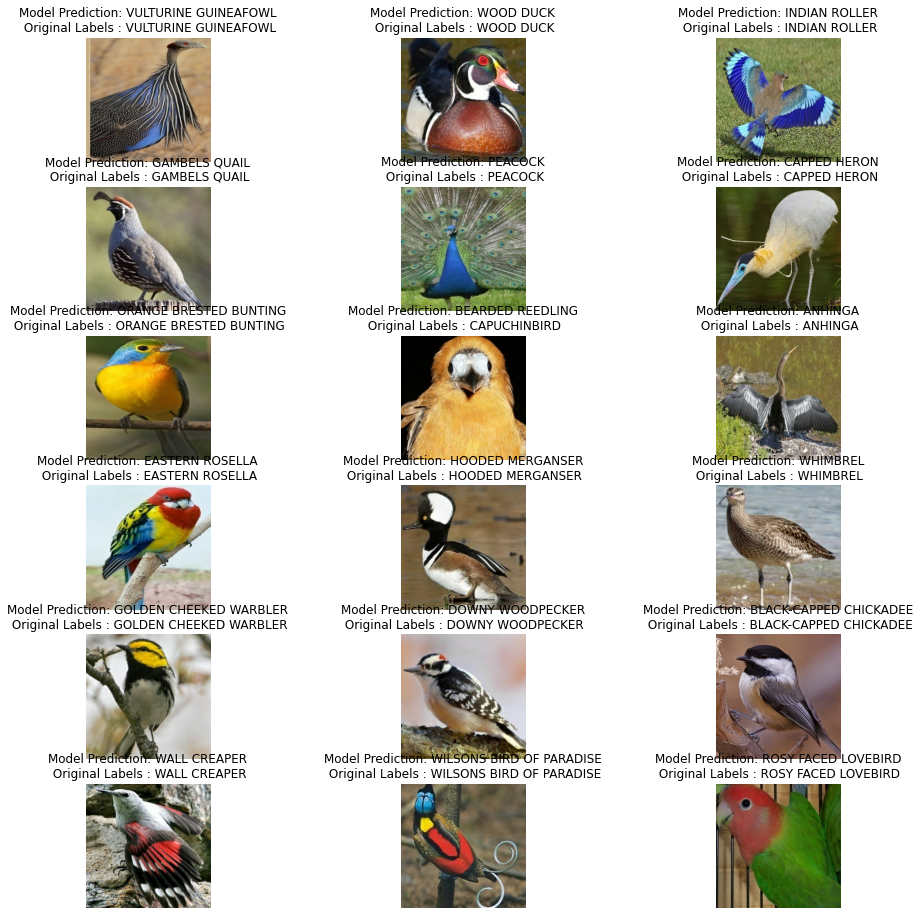

In [140]:
# predicting and visualizing the predicted images and class

import matplotlib.pyplot as plot
import tensorflow as tf

plt.figure(figsize=(16,16))

for image, label in test_data.take(1):
  model_prediction = eff_model.predict(image)
  for i in range(18):
    plt.subplot(6,3,i+1)
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.title(f"Model Prediction: {test_labels[tf.argmax(tf.round(model_prediction[i]))]}\n Original Labels : {test_labels[tf.argmax(label[i])]}")
    plt.axis("off")
